In [3]:
import pandas as pd
import sweetviz as sv
from pycaret.classification import *
import featuretools as ft
from sympy import sympify


def read_dataset():
    data = pd.read_csv('../data/6K_5R_HNR_set6.csv', sep=',')
    labels = pd.DataFrame()
    records = data["ViolatedRule"].str.split(",", expand = True)
    for i in range(records.shape[1]):
        labels[f"ViolatedRule{i}"]= records[i]
        labels.loc[labels[f"ViolatedRule{i}"] != "-1", f"ViolatedRule{i}"] = 1
        labels.loc[labels[f"ViolatedRule{i}"] == "-1", f"ViolatedRule{i}"] = 0

    return data, labels


def eda(data):
    # skip=["proline", "magnesium"],
    config = sv.FeatureConfig(force_num=['ViolatedRule'])
    my_report = sv.analyze(data, feat_cfg=config, target_feat='ViolatedRule')
    my_report.show_html()
    # profile = ProfileReport(data, title="Pandas Profiling Report")
    # profile.to_file(output_file=pathlib.Path("./data_report.html"))
    # profile.to_widgets()


def stack():
    top3 = compare_models(n_select=3)
    tuned_top3 = [tune_model(i) for i in top3]
    blender = blend_models(tuned_top3)
    stacker = stack_models(tuned_top3)
    best_auc_model = automl(optimize='AUC')
    print(best_auc_model)


def multi_level_feature_creation(X, trans_primitives_per_level): 
    feature_matrix = X
    initial_columns = X.columns

    
    for i,trans_primitives in enumerate(trans_primitives_per_level):
        print("Level: ", i)
        
        print("Columns: ", feature_matrix.columns)
        print(trans_primitives)
    
        es = ft.EntitySet(id = 'dataset')
    
        dataframe_name = "data" + str(i)
    
        es = es.add_dataframe(
            dataframe_name=dataframe_name,
            dataframe=feature_matrix,
            index="index" + str(i)
        )        

        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = dataframe_name, trans_primitives = trans_primitives)
        
        #Simplify
        print(feature_matrix.shape)
        feature_matrix = feature_matrix.rename(columns={
            c: str(sympify(c)) for c in feature_matrix.columns
        })
        
        # This is needed to reset ww data 
        feature_matrix = pd.DataFrame(feature_matrix.to_dict())

    feature_matrix.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return feature_matrix, feature_defs

def static_features(features):
    features['left_diff'] = abs(features['LeftSideFirst'] - features['LeftSideLast'])
    features['right_diff'] = abs(features['RightSideFirst'] - features['RightSideFirst'])
    features['left_dens'] = features['left_diff'] / features['Length']
    features['right_dens'] = features['right_diff'] / features['Length']

    return features


def clean_dataset(features):
    
    features['LeftSideFirst'] = features['LeftSideFirst'].apply(lambda value: ''.join(i for i in str(value) if i.isdigit()))
    features['LeftSideLast'] = features['LeftSideLast'].apply(lambda value: ''.join(i for i in str(value) if i.isdigit()))
    features['RightSideFirst'] = features['RightSideFirst'].apply(lambda value: ''.join(i for i in str(value) if i.isdigit()))
    features['RightSideLast'] = features['RightSideLast'].apply(lambda value: ''.join(i for i in str(value) if i.isdigit()))
    features = features.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)
    types_dict = {}
    for column in features.columns.values:
        types_dict[column] = 'float'

    features = features.astype(types_dict)
    return features

def eval_model(features,labels, column):
    print(column)
    #print(labels[column].value_counts())
    dataset = pd.concat([features,labels[column]], axis=1)
    s = setup(dataset, target=column, silent=True, log_experiment=False, experiment_name='first_rule', fix_imbalance=True)
    # best = compare_models()
    # results = pull()
    # print(results.head())
    investigated = create_model('xgboost')

    #models()
    
    #deep_check(investigated)
    tuned_investigated = tune_model(investigated, choose_better=True, n_iter = 10, search_library = 'optuna', search_algorithm = 'tpe')
    tuned_investigated
    plot_model(tuned_investigated, plot='pr')
    plot_model(investigated, plot='feature')
    plot_model(investigated, plot='confusion_matrix')
    
    evaluate_model(tuned_investigated)
    predict_model(tuned_investigated)
    final_rf = finalize_model(tuned_investigated)

In [4]:
drop_columns=['txId', 'FeatureID', 'ViolatedRule', 'LeftSideIntermediate', 'RightSideIntermediate']
catgories_columns=['HouseNumberVariance', 'LeftSideInterpolation', 'RightSideInterpolation','fow']
features, labels = read_dataset()

features = features.drop(columns=drop_columns)
categories_features = features[catgories_columns]
features = features.drop(columns=catgories_columns)

features = clean_dataset(features)
features.info()
features
features_per_level = [['subtract_numeric', 'add_numeric', 'multiply_numeric', 'divide_numeric'], 
                      ['absolute'], 
                      ['divide_numeric']] #         ['add_numeric', 'multiply_numeric', 'subtract_numeric', 'divide_numeric', 'multiply_numeric_scalar']
features, _ = multi_level_feature_creation(features, features_per_level)
#features = static_features(features)

features = pd.concat([features, categories_features], axis=1)

features.to_csv('../data/output_6K_5R_HNR_set6_out.csv')
# eda(data)

# print(features.info())
# print(features.describe().transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LeftSideFirst   1506 non-null   float64
 1   LeftSideLast    1506 non-null   float64
 2   RightSideFirst  1479 non-null   float64
 3   RightSideLast   1479 non-null   float64
 4   Length          1860 non-null   float64
dtypes: float64(5)
memory usage: 72.8 KB
Level:  0
Columns:  Index(['LeftSideFirst', 'LeftSideLast', 'RightSideFirst', 'RightSideLast',
       'Length'],
      dtype='object')
['subtract_numeric', 'add_numeric', 'multiply_numeric', 'divide_numeric']
(1860, 55)
Level:  1
Columns:  Index(['LeftSideFirst', 'LeftSideLast', 'RightSideFirst', 'RightSideLast',
       'Length', 'LeftSideFirst + LeftSideLast', 'LeftSideFirst + Length',
       'LeftSideFirst + RightSideFirst', 'LeftSideFirst + RightSideLast',
       'LeftSideLast + Length', 'LeftSideLast + RightSideFirst',
       'L

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


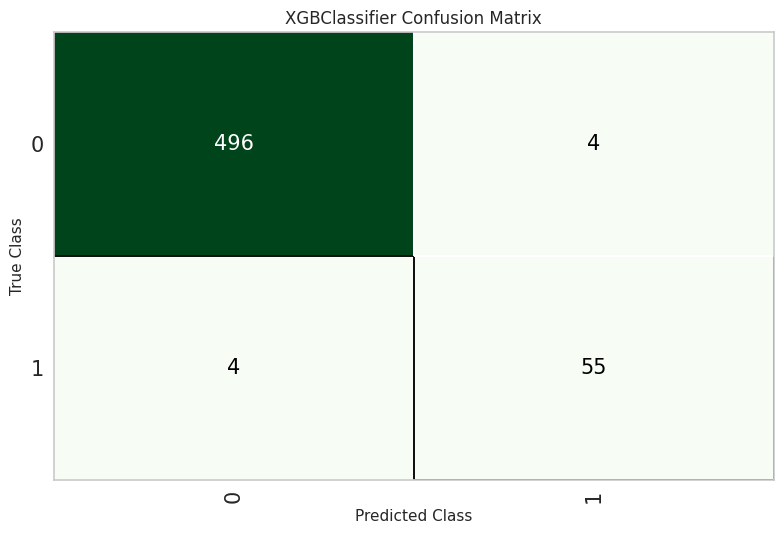

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9857,0.9991,0.9322,0.9322,0.9322,0.9242,0.9242


In [5]:
# models generator per Rule
# because results are overwritten index == 0 
for index, column in enumerate(labels.columns.values):
    if column.startswith('ViolatedRule') and index==0:
        eval_model(features,labels,column)

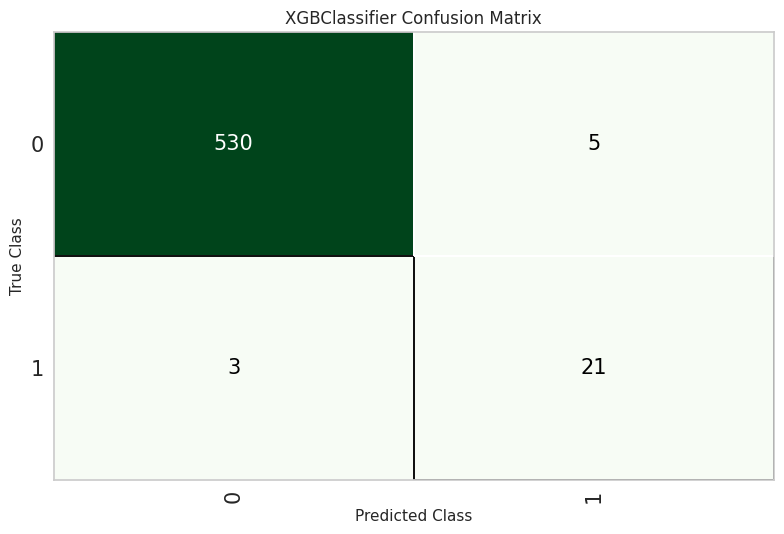

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9857,0.9967,0.8750,0.8077,0.8400,0.8325,0.8333


In [6]:
eval_model(features,labels,'ViolatedRule1')

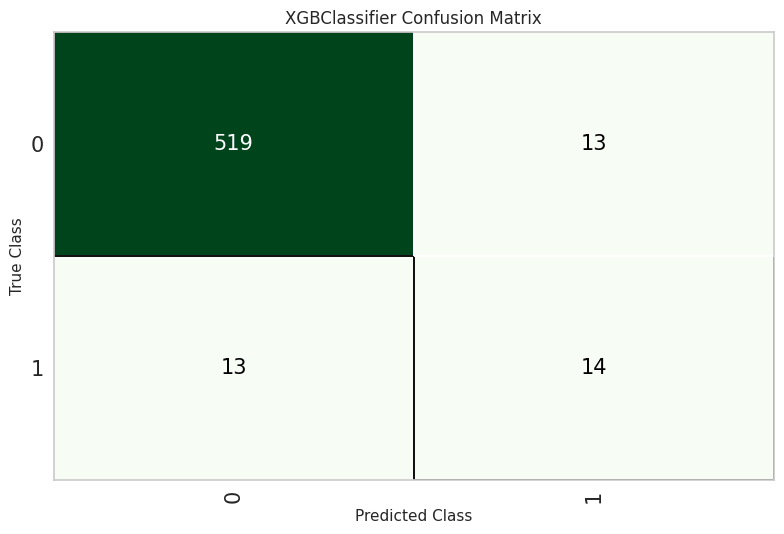

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9535,0.9741,0.5185,0.5185,0.5185,0.4941,0.4941


In [7]:
eval_model(features,labels,'ViolatedRule2')

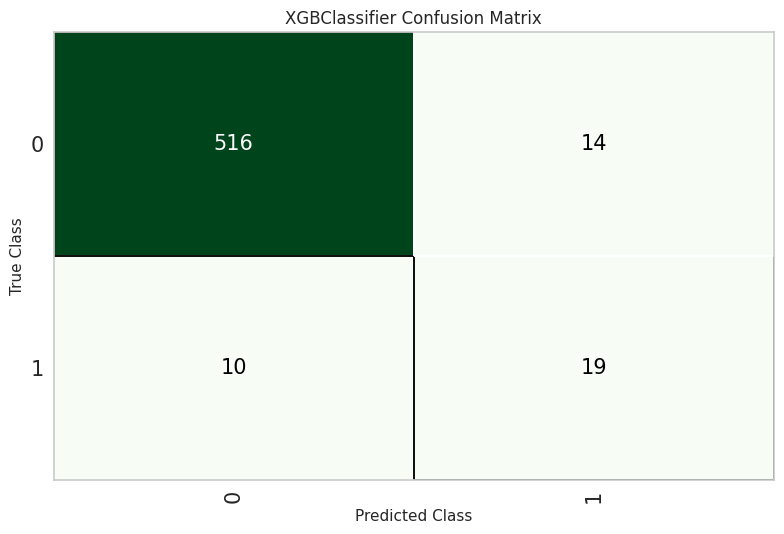

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9571,0.9325,0.6552,0.5758,0.6129,0.5903,0.5917


In [8]:
eval_model(features,labels,'ViolatedRule3')

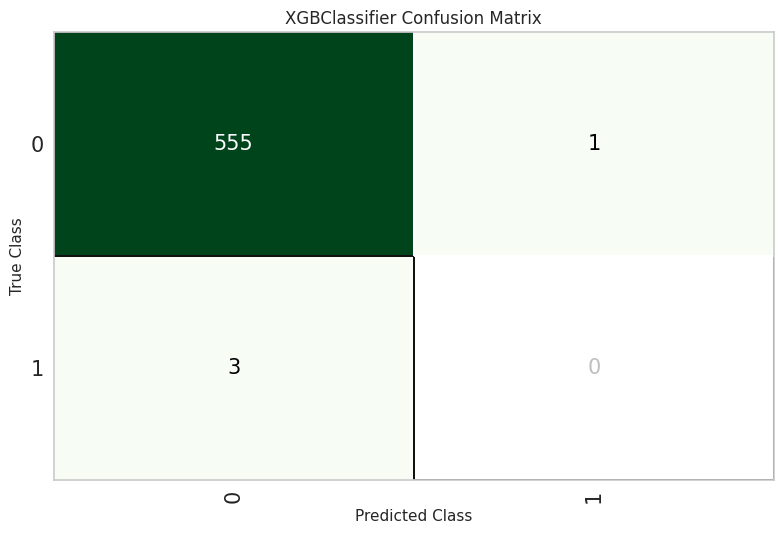

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9928,0.9676,0.0000,0.0000,0.0000,-0.0027,-0.0031


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.8/site-packages/sklearn

In [9]:
eval_model(features,labels,'ViolatedRule4')